# Efficient computation of optimal actions

# Grid world

In this tutorial, we use a classic grid world tasks to illustrate concepts presented in the paper.

In [1]:
# Custom pymdp module with SI agent
import pymdp
import numpy as np

# Importing custom environment class
from grid_env_si import grid_environment as Env

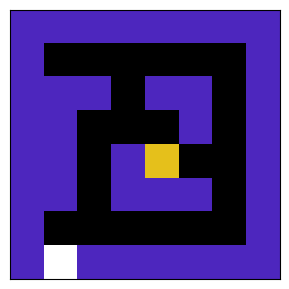

In [2]:
# Initialising the environment 
env = Env(path = "grid_25.txt", mdppath = 'mdp_25.txt', epi_length_limit = 15)

# Taking a look at the grid
env.render()

In this particular grid, we can see how an agent might around with actions such as "Left", "Right", "Up", "Down", etc. The transition probabilites are encoded in the classical way as:

In [3]:
# Custom pymdp module with SI agent
import pymdp

num_states = 25
num_controls = 4

# B Matrix
B = pymdp.utils.random_B_matrix(num_states, num_controls)
B[0] = env.get_trueB()

In [4]:
# Example transition from state-2 taking action-0
B[0][:,2,0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

# Particular class of MDPs (Linearly solvable)

The paper aims to construct a general class of MDPs that can have analytical solutions. This calls for MDPs with continuous actions states. Quoting from the paper:
This may seem counterintuitive if one thinks of actions as symbols (“go left,” “go right”). However, what gives meaning to such symbols are the underlying transition probabilities—which are continuous. The latter observation is key to the framework developed here. Instead of asking the agent to specify symbolic actions, which are then replaced with transition probabilities, we allow the agent to specify transition probabilities u(x' | x) directly. 
Formally, we have p(x' | x, u) = u(x' | x).

B[0][:,:,0] --> This is nothing but the corresponsind action to move Up(x',x) distribution.

Similary,

B[0][:,:,1] --> Down(x',x) distribution.

B[0][:,:,2] --> Right(x',x) distribution.

B[0][:,:,3] --> Left(x',x) distribution.

Another important parameter is the passive dynamics p(x'|x) distribution. The passive dynamics p(x' | x) and controlled dynamics u(x' | x) can also be arbitrary, except that we require u(x' | x) = 0 whenever p(x' | x) = 0. This constraint is needed to make KL divergence well-defined. It has the added benefit of preventing the agent from jumping directly to goal states, and more generally from making state transitions that are physically impossible.

Here we attempt to construct a passive dynamics for our environment from the given MDP where allowable transitions are given equal weightage.

## Passive dynamics

In [5]:
# P Matrix is constructed with all allowable transitions.

P = pymdp.utils.random_B_matrix(num_states, 1)*0

In [6]:
for i in range(num_controls):
    for j in range(num_states):
        for k in range(num_states):
            P[0][k,j,0] = 1 if (B[0][k,j,i] == 1 or P[0][k,j,0] == 1) else 0
            
P = pymdp.utils.norm_dist_obj_arr(P)
Pr = P[0][:,:,0]

## Cost of transitions

Now, we have to construct a cost matrix q(x), that encodes how (un)deseriable a state x is.

In [7]:
Q = pymdp.utils.obj_array_ones([num_states])*1

In [8]:
Q[0][env.end_state] = 0
Q = pymdp.utils.norm_dist_obj_arr(Q)
Q[0]

array([0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
       0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
       0.04166667, 0.04166667, 0.04166667, 0.        , 0.04166667,
       0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
       0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667])

# Part 1: Z Iteration

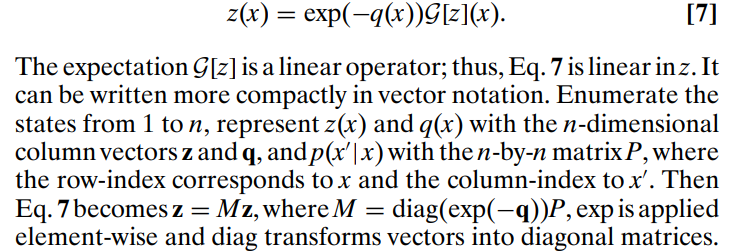

In [9]:
#Initial guess of z 
z = pymdp.utils.obj_array_ones([num_states])
z[0] = z[0].reshape(num_states,1)

#Constructing M
diag_q = np.diag(np.exp(-Q[0]))
diag_q.shape

M = np.matmul(diag_q, Pr.T)

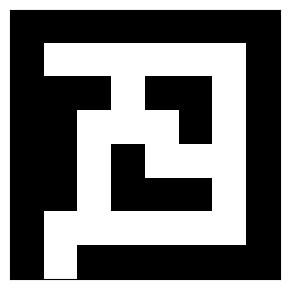

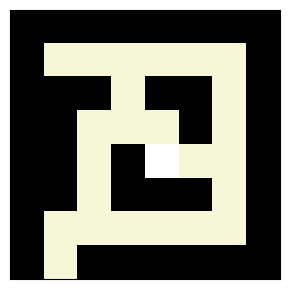

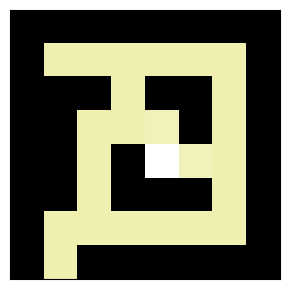

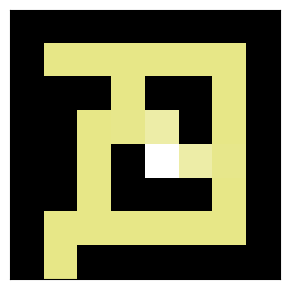

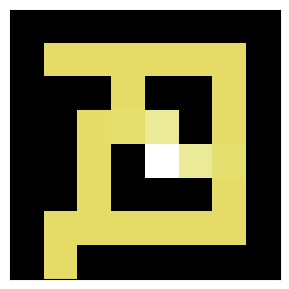

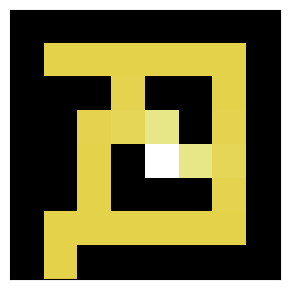

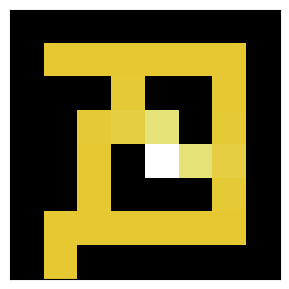

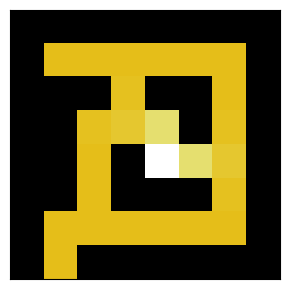

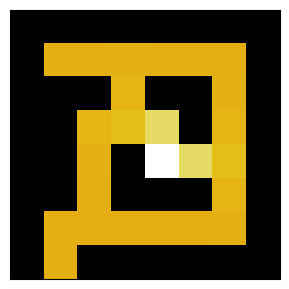

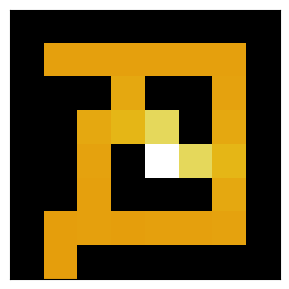

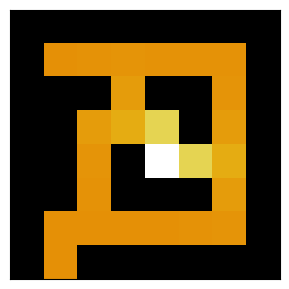

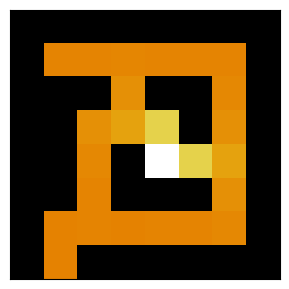

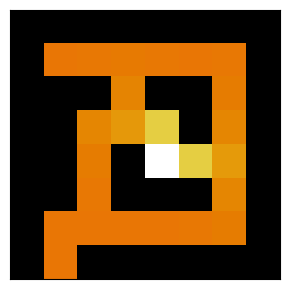

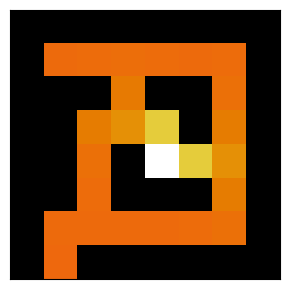

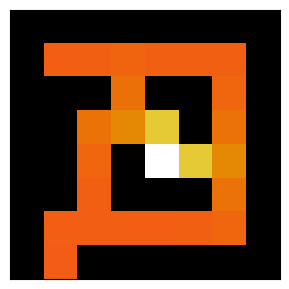

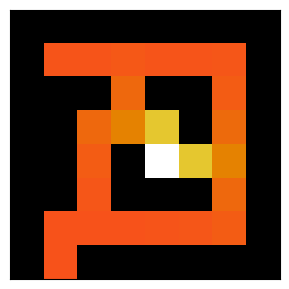

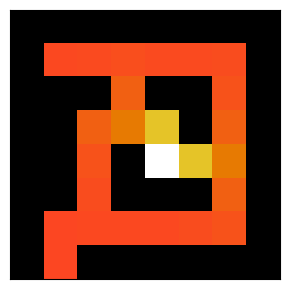

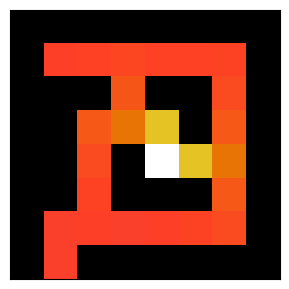

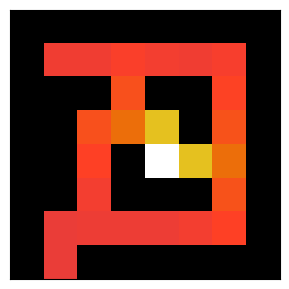

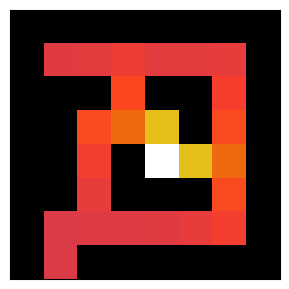

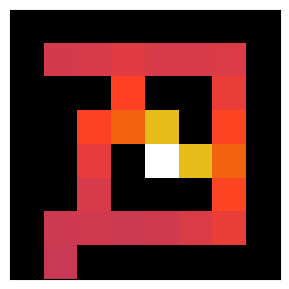

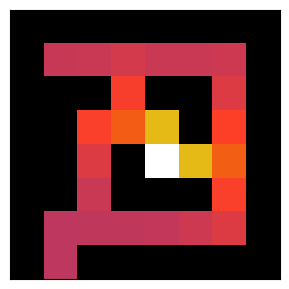

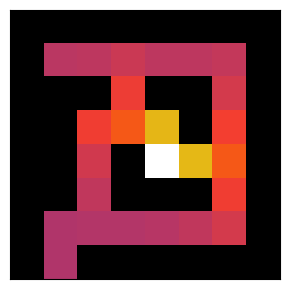

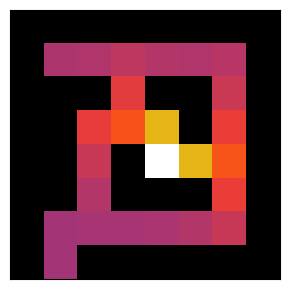

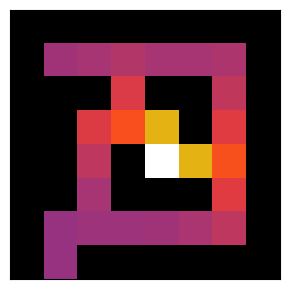

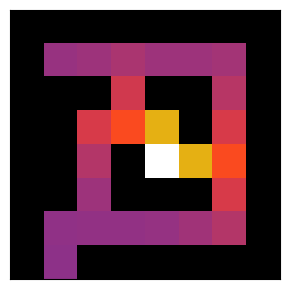

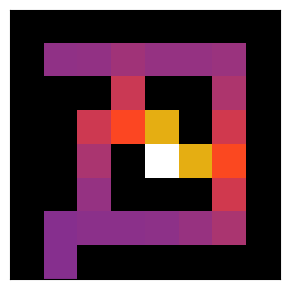

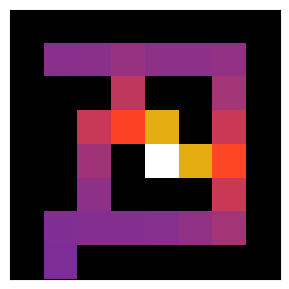

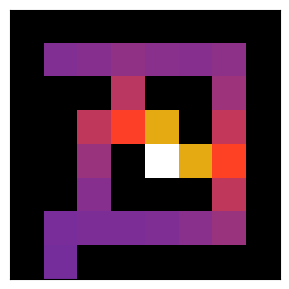

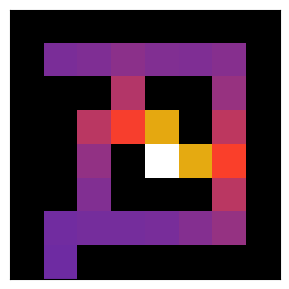

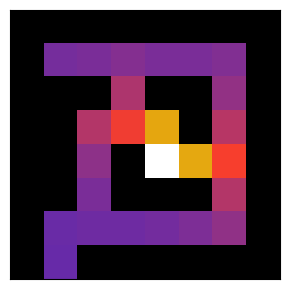

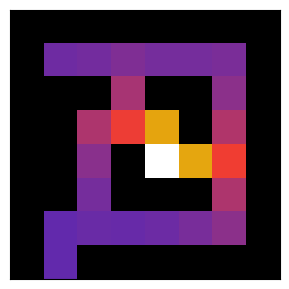

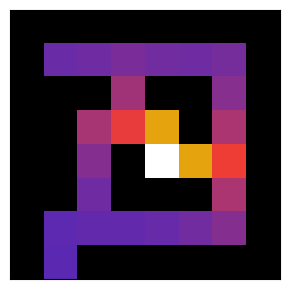

No of iterations: 33


In [10]:
done = False
count = 0

while(done == False):
    count += 1
    c = np.zeros((8,8))

    for i in range(num_states):
        [x,y] = env.statestoc(i)
        c[x][y] = z[0][i]
    
    env.render_c_matrix(c = c)
    
    z_old = np.copy(z)
    z[0] = np.matmul(M, z_old[0])
    
    done = True if np.allclose(z[0], z_old[0], atol = 1e-2) else False
    if(count > 100):
        done = True

print("No of iterations:", count)

## Choosing an optimal action from the desirability function

We use the argmax method to choose the desirable next state, as well as for actions using the transition dynamics as:
B[0][u_star, obs, :].argmax()

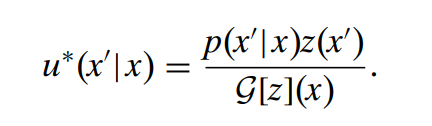

Say for an example current state, 24:

In [11]:
current_state = 24
u_star = np.multiply(P[0][:,current_state], z[0])
u_star /= u_star.sum()
next_desrired_state = u_star.argmax()
print(current_state, next_desrired_state)

24 18


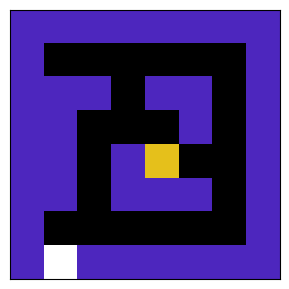

24 0


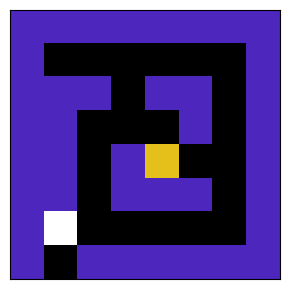

18 2


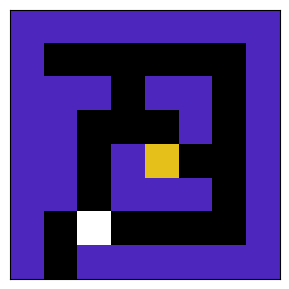

19 0


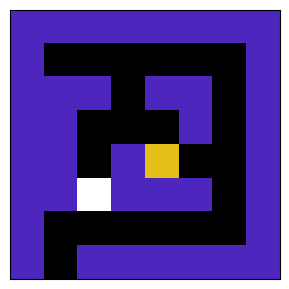

16 0


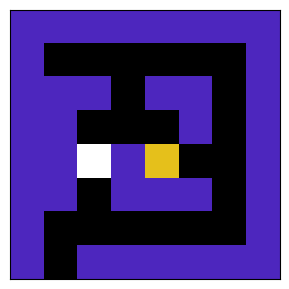

12 0


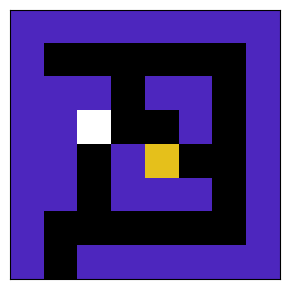

8 2


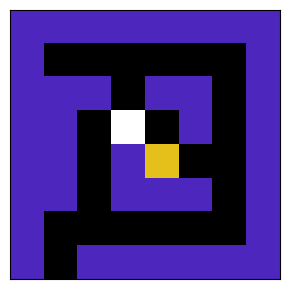

9 2


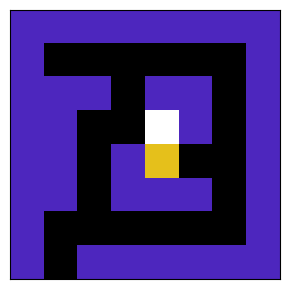

10 1


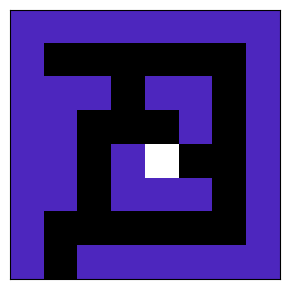

In [12]:
# Resetting the grid-environment for trial
obs, info = env.reset(seed=42)

# trial
done = False
tau = 0

while(done==False):
    env.render()

    # agent-step
    numer = np.multiply(P[0][:,obs], z[0])
    u_star = (numer / numer.sum()).argmax()
    action = B[0][u_star, obs, :].argmax()
    
    print(obs, action)

    # Env-step
    obs, reward, terminated, truncated, info = env.step(int(action))
    tau += 1
    # Checking for succesful episode
    if terminated or truncated:
        done = True

# Talking a look at the environment
# env.render(animation_save = True, N = planning_depth, tau = tau)
env.render()

# Part 2: Desirability function from solving a linear equation

With the additional knowledge about terminal and non-terminal states we can solve for the desirability function directly.
Let us use equation 8 from the paper:
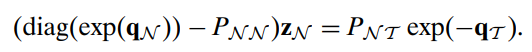

In [13]:
ter_state = 13

#Constructing LHS
Qn = np.ones([num_states - 1 , 1])*0.1

X = np.delete(Pr, 13, 0)
Pnn = np.delete(X, 13, 1)

dqn = np.diag(np.exp(Qn[:,0]))
A = dqn - Pnn

In [14]:
# Constructing RHS

Pnt = np.delete(Pr[13, :], 13).reshape(24,1)

b = Pnt*np.exp(0)

In [15]:
# Solving the linear equation

In [16]:
zan = np.linalg.solve(A, b)

# Manually inserting desirability for terminal(goal) state:
zan = np.insert(zan, 13, zan.max()+0.1)

In [17]:
zan

array([0.02329624, 0.04229462, 0.08398583, 0.04598857, 0.04349775,
       0.05473103, 0.12718353, 0.08323264, 0.13287418, 0.30867429,
       0.53185011, 0.13799522, 0.07616615, 0.63391934, 0.53391934,
       0.31506273, 0.0434895 , 0.13638289, 0.01647375, 0.03271247,
       0.023961  , 0.03094766, 0.04769869, 0.07949927, 0.00907388])

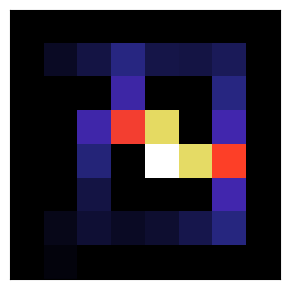

In [18]:
c = np.zeros((8,8))

for i in range(num_states):
    [x,y] = env.statestoc(i)
    
    c[x][y] = zan[i]

env.render_c_matrix(c = c)

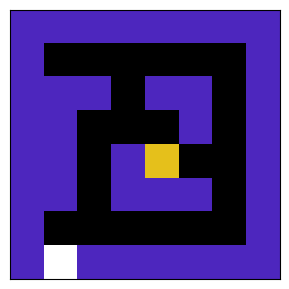

24 18 0


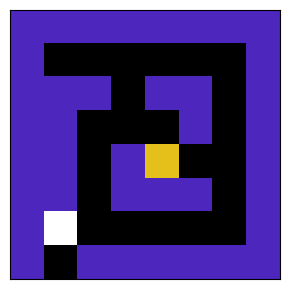

18 19 2


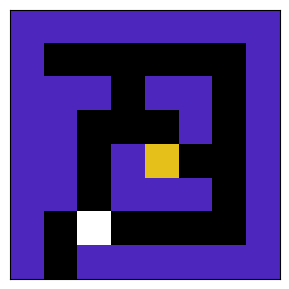

19 16 0


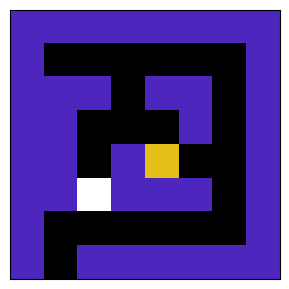

16 12 0


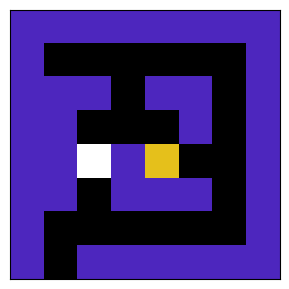

12 8 0


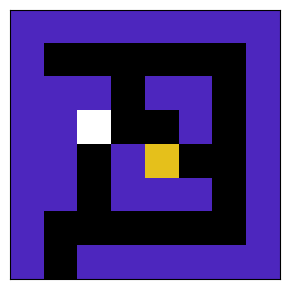

8 9 2


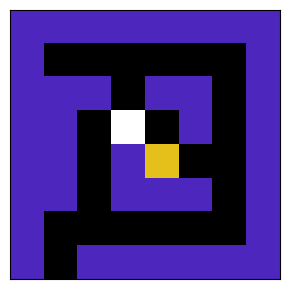

9 10 2


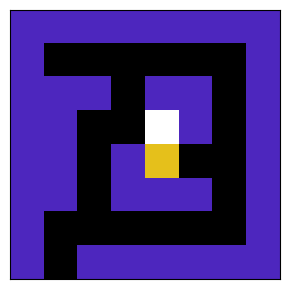

10 13 1


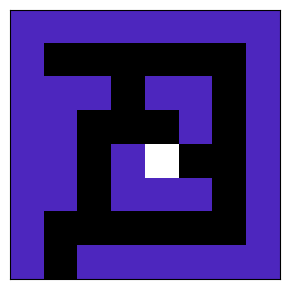

In [19]:
# Resetting the grid-environment for trial
obs, info = env.reset(seed=42)

# trial
done = False
tau = 0

while(done==False):
    env.render()

    # agent-step
    numer = np.multiply(P[0][:,obs], zan.reshape(25,1))
    u_star = numer.argmax()
    action = B[0][u_star, obs, :].argmax()
    
    print(obs, u_star, action)

    # Env-step
    obs, reward, terminated, truncated, info = env.step(int(action))
    tau += 1
    # Checking for succesful episode
    if terminated or truncated:
        done = True

# Talking a look at the environment
# env.render(animation_save = True, N = planning_depth, tau = tau)
env.render()

# Part 3: Z learning

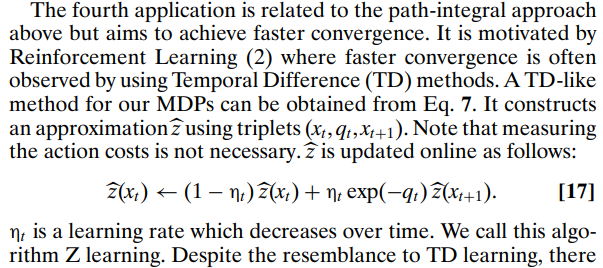

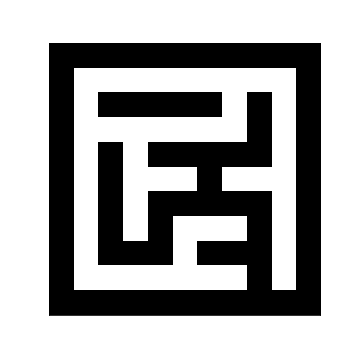